In [1]:
import pandas as pd

In [2]:
file_path = "/Users/jameskrice/climate_change_corpus.csv"

In [3]:
# Load the dataset into a DataFrame
climate_corpus_df = pd.read_csv(file_path)

In [4]:
# Display the first few rows of the dataset to understand its structure
print(climate_corpus_df.head())

                                               title  \
0                The structure of the climate debate   
1                           Baumol's Climate Disease   
2  You are right. I am ALARMED -- But by Climate ...   
3  Climate Change Conspiracy Theories on Social M...   
4  Hurricanes Increase Climate Change Conversatio...   

                                              author  year  \
0                              \nRichard S. J. Tol\n  2016   
1  \nFangzhi Wang\n, \nHua Liao\n, \nRichard S. J...  2023   
2  \nShraey Bhatia\n, \nJey Han Lau\n, \nTimothy ...  2020   
3             \nAman Tyagi\n, \nKathleen M. Carley\n  2021   
4  \nMaddalena Torricelli\n, \nMax Falkenberg\n, ...  2023   

                                                text source  word_count  \
0    First-best climate policy is a uniform carbo...  arXiv         102   
1    We investigate optimal carbon abatement in a...  arXiv         120   
2    The world is facing the challenge of climate...  arXiv      

In [5]:
# Basic information about the dataset
print(climate_corpus_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   title                               154 non-null    object
 1   author                              154 non-null    object
 2   year                                154 non-null    int64 
 3   text                                154 non-null    object
 4   source                              154 non-null    object
 5   word_count                          154 non-null    int64 
 6   contains_misinformation_indicators  154 non-null    bool  
dtypes: bool(1), int64(2), object(4)
memory usage: 7.5+ KB
None


In [6]:
# Check for any missing values
print(climate_corpus_df.isnull().sum())

title                                 0
author                                0
year                                  0
text                                  0
source                                0
word_count                            0
contains_misinformation_indicators    0
dtype: int64


In [7]:
# Filter the dataset for rows where 'contains_misinformation_indicators' is True
misinformation_sources = climate_corpus_df[
    climate_corpus_df['contains_misinformation_indicators'] == True
]

In [8]:
# Count the number of articles from each source with misinformation
misinformation_source_counts = misinformation_sources['source'].value_counts()

In [12]:
# Convert the counts to a DataFrame for better readability
misinformation_source_counts_df = misinformation_source_counts.reset_index()
misinformation_source_counts_df.columns = ['Source', 'Count']

In [13]:
# Display the resulting DataFrame
print(misinformation_source_counts_df)

Empty DataFrame
Columns: [Source, Count]
Index: []


In [17]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jameskrice/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jameskrice/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    return ' '.join([word for word in tokens if word.isalpha() and word not in stop_words])


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = vectorizer.fit_transform(climate_corpus_df['text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust n_components for topics
lda.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [23]:
# Get the feature names (i.e., words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Define a function to extract top keywords for each topic
def display_topics(model, feature_names, num_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        # Get the indices of the top keywords for the topic
        top_features_idx = topic.argsort()[-num_top_words:][::-1]
        # Map the indices to the actual words
        top_features = [feature_names[i] for i in top_features_idx]
        topics.append({
            "Topic": topic_idx,
            "Keywords": ", ".join(top_features)
        })
    return topics

# Specify the number of top words you want per topic
num_top_words = 10

# Generate the list of topics with their top keywords
topics_with_keywords = display_topics(lda, feature_names, num_top_words)

# Convert to a DataFrame for better readability
topics_df = pd.DataFrame(topics_with_keywords)

# Display the DataFrame
print(topics_df)


   Topic                                           Keywords
0      0  warming, global, temperature, surface, model, ...
1      1  change, climate, warm, public, media, method, ...
2      2  climate, change, economic, model, impacts, eff...
3      3  climate, change, data, models, policy, researc...
4      4  sea, ice, observations, observed, models, tren...


In [20]:
import numpy as np

topic_assignments = np.argmax(lda.transform(dtm), axis=1)
climate_corpus_df['topic'] = topic_assignments

In [21]:
topic_over_time = climate_corpus_df.groupby(['year', 'topic']).size().unstack(fill_value=0)

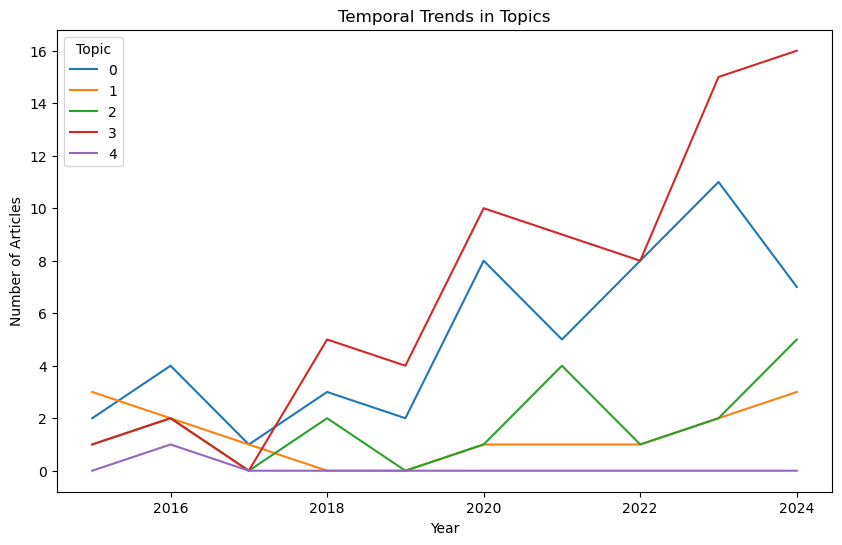

In [22]:
import matplotlib.pyplot as plt

topic_over_time.plot(figsize=(10, 6))
plt.title('Temporal Trends in Topics')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.legend(title='Topic')
plt.show()

In [24]:
# Function to extract representative keywords for each topic
def get_representative_keywords(model, feature_names, top_n):
    keywords = {}
    for topic_idx, topic in enumerate(model.components_):
        # Get the indices of the top keywords
        top_features_idx = topic.argsort()[-top_n:][::-1]
        # Map indices to words
        top_features = [feature_names[i] for i in top_features_idx]
        keywords[topic_idx] = top_features
    return keywords

# Get top 1 or 2 representative keywords for each topic
top_n_keywords = 2
representative_keywords = get_representative_keywords(lda, feature_names, top_n_keywords)

# Display representative keywords for each topic
for topic, words in representative_keywords.items():
    print(f"Topic {topic}: {', '.join(words)}")


Topic 0: warming, global
Topic 1: change, climate
Topic 2: climate, change
Topic 3: climate, change
Topic 4: sea, ice


In [26]:
# Map topics to their representative keywords
topic_labels = {topic: ", ".join(words) for topic, words in representative_keywords.items()}

# Add a 'topic_label' column to the DataFrame
climate_corpus_df['topic_label'] = climate_corpus_df['topic'].map(topic_labels)

In [27]:
# Group by year and topic_label
topics_over_time = climate_corpus_df.groupby(['year', 'topic_label']).size().unstack(fill_value=0)

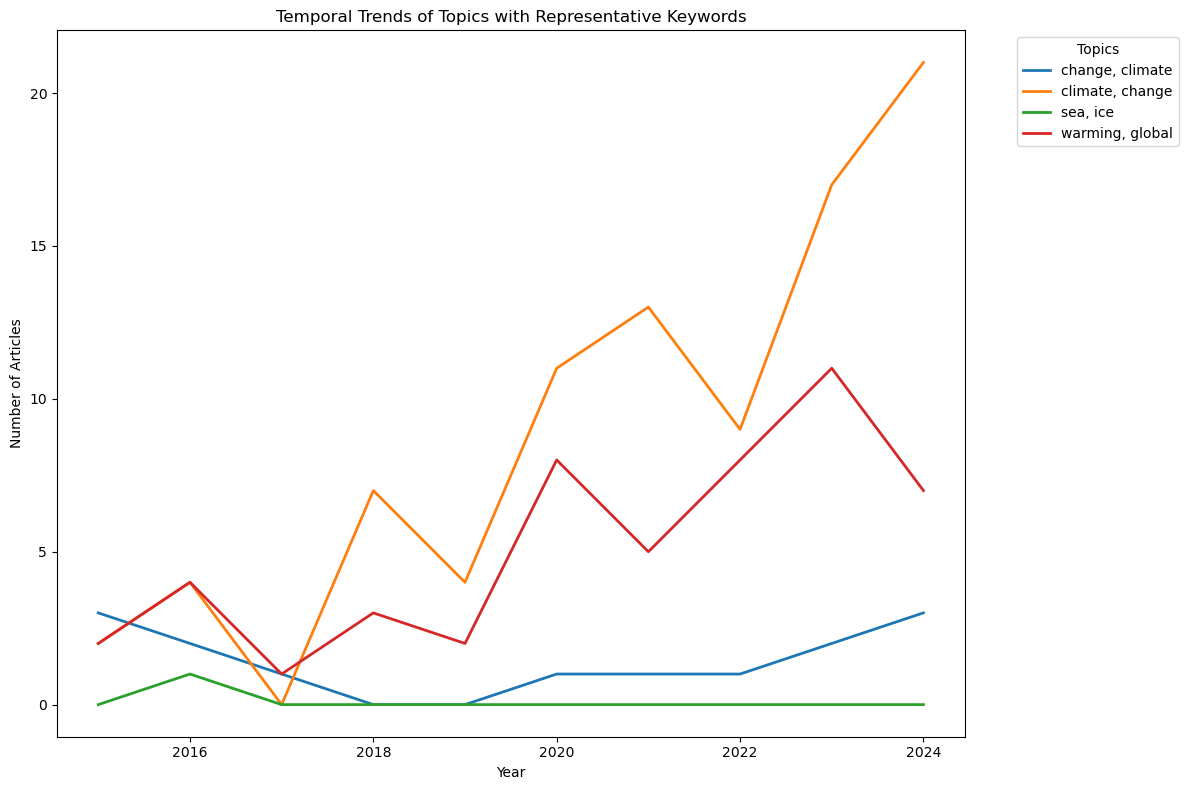

In [28]:
import matplotlib.pyplot as plt

# Plot the trends
topics_over_time.plot(figsize=(12, 8), linewidth=2)
plt.title('Temporal Trends of Topics with Representative Keywords')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()